In [2]:
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

from ho_stray_field import *
from ho_stray_field.bspline import BSpline
from ho_stray_field.tensor_grid import TensorGrid
from ho_stray_field.magnetostatic import PotentialState, solve_energy, fit_mag
from ho_stray_field.sources import m_uniform, flower_state, vortex_state
from ho_stray_field.utils import write_csv_row

jax.config.update("jax_enable_x64", True)

# Higher order stray field magnetostatic energy computation

In this notebook, the higher order stray field method is used for magnetostatic energy
computation. 

First we define the `setup` and the `solve` function. `setup` initializes a solver for the respective domain and computes factor matrices to solve the superpotential. The `solve` function computes the
magnetostatic energy.

In [ ]:

@partial(jax.jit, static_argnames=("s", "potential"))
def setup(model, target_tg, mag_model=None, s=100, potential="superpotential"):
    state = PotentialState.init(
        pot_elm=model,
        mag_elm=mag_model,
        pot_quad_grid=target_tg,  # use same quadrature grid everywhere
        mag_quad_grid=target_tg,
        target_quad_grid=target_tg,
        gs_terms=s,
        gk_epsabs=1e-13,
        gk_epsrel=0.0,
        gk_order=41,
        gk_max_ninter=50,
        potential=potential
    )
    return state

@jax.jit
def solve(state: PotentialState, mag) -> jax.Array:
    return solve_energy(state, mag)


def make_cube_model(k: int, r: int):
    grid = TensorGrid(*[jnp.linspace(-0.5, 0.5, r)] * 3)
    model = BSpline(grid, degree=k - 1)
    return model

## Energy for a uniformly magnetized cube

We solve the energy for a uniform magnetization within the unit cube. The magnetization is fitted with a B-spline with a multilinear grid rank ($\bar r^k \equiv \bar r_p^k=r_p-k+2=30$) and the same order as for the field. We could also set $r_p=1$ and $k=1$ to perfectly fit the uniform magnetization, but we use a higher rank so that the model could potentially adjust to a more complex magnetization, e.g. during LLG integration.

Field and energy is computed for different ranks $r_k'$ and different B-spline orders $k$. The number of exponential sum terms $S=100$ is used. For all fitting procedures 200 Gauss-Legendre quadrature points for each dimension. 

In [ ]:
# uniform state
e_true = 1 / 6
ks = [4, 5, 6, 7, 8, 9]
rs = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
r_mag = 30

target_tg = TensorGrid(*[jnp.linspace(-0.5, 0.5, 2)] * 3).to_gauss(200)

for k in ks:
    for r in rs:
        model, mag_model = make_cube_model(k, r), make_cube_model(k, r_mag)
        solver = setup(model, target_tg, mag_model=mag_model, s=100)
        mag = fit_mag(solver, m_uniform)  # prefit magnetization to functional Tucker format
        e = solve(solver, mag).block_until_ready()
        err = jnp.abs(e - e_true)
        t = %timeit -q -o -n 5 -r 1 solve(solver, mag).block_until_ready()
        print(f"k={k}, r={r}, energy={e:.6e}, error={err:.4e}, fitting_time={t.average * 1000:.3f} ms")
        data = {
            "k": k,
            "r": r,
            "s": 100,
            "energy": e,
            "error": jnp.abs(e - 1 / 6),
            "run_time": t.average
        }
        write_csv_row("results/energy_uniform.csv", data)

k=4, n=10, energy=1.620807e-01, error=4.5860e-03, fitting_time=4.385 ms
k=4, n=15, energy=1.644359e-01, error=2.2307e-03, fitting_time=4.661 ms
k=4, n=20, energy=1.654080e-01, error=1.2587e-03, fitting_time=5.325 ms
k=4, n=25, energy=1.658590e-01, error=8.0766e-04, fitting_time=7.034 ms
k=4, n=30, energy=1.661169e-01, error=5.4981e-04, fitting_time=7.380 ms
k=4, n=35, energy=1.662727e-01, error=3.9396e-04, fitting_time=8.960 ms
k=4, n=40, energy=1.663655e-01, error=3.0119e-04, fitting_time=12.228 ms
k=4, n=45, energy=1.664380e-01, error=2.2862e-04, fitting_time=12.852 ms
k=4, n=50, energy=1.665163e-01, error=1.5039e-04, fitting_time=15.567 ms
k=4, n=55, energy=1.665415e-01, error=1.2513e-04, fitting_time=18.433 ms
k=4, n=60, energy=1.665346e-01, error=1.3211e-04, fitting_time=21.914 ms
k=4, n=65, energy=1.665617e-01, error=1.0493e-04, fitting_time=27.309 ms
k=4, n=70, energy=1.666105e-01, error=5.6207e-05, fitting_time=32.892 ms
k=5, n=10, energy=1.669192e-01, error=2.5256e-04, fitting

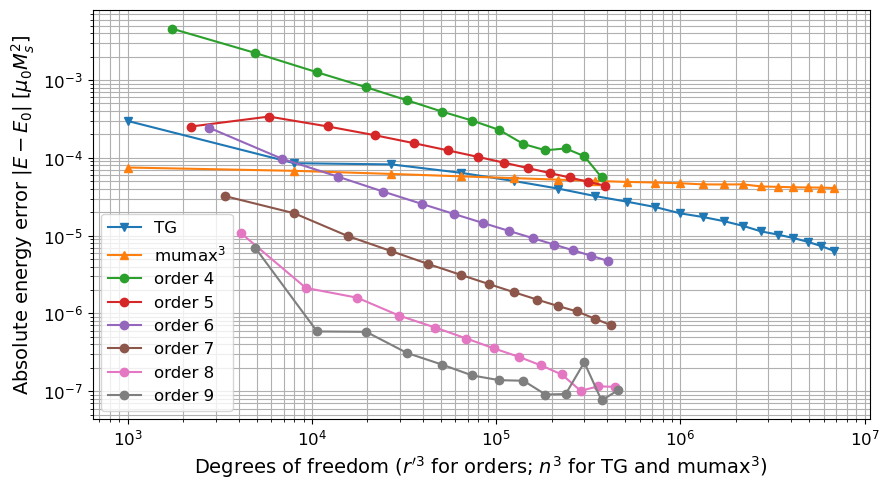

In [4]:
tg_result = pd.read_csv("results/TG_uniform_cube_table.txt", sep=" ")
mumag3_result = pd.read_csv("results/mumax_uniform_state.csv")
mumag3_result["DoF"] = mumag3_result.Nx * mumag3_result.Ny * mumag3_result.Nz
mumag3_result["error"] = abs(mumag3_result.energy - 1 / 6)
hosf_result = pd.read_csv("results/energy_uniform.csv")
ks = hosf_result.k.unique()

e_true = 1 / 6
fig = plt.figure(figsize=(9, 5))

plt.plot(tg_result.DoF[:-1], abs(tg_result.energy[:-1] - 1 / 6), "-v", label="TG")
plt.plot(mumag3_result.DoF[:-1], mumag3_result.error[:-1], "-^", label=r"mumax$^3$")
for k in ks:
    res = hosf_result[hosf_result.k == k]
    plt.plot([(_n + k - 2)**3 for _n in res.r], abs(res.energy - 1 / 6), "-o", label = f"order {k}")
    
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"Degrees of freedom ($r'^3$ for orders; $n^3$ for TG and mumax$^3$)", fontsize=14)
plt.ylabel(r"Absolute energy error $|E - E_0|$ $[\mu_0 M_s^2]$", fontsize=14)
plt.grid(which="both")
plt.legend(fontsize=12)
plt.gca().tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
fig.savefig("results/uniform_error_comparison.pdf")
plt.show()

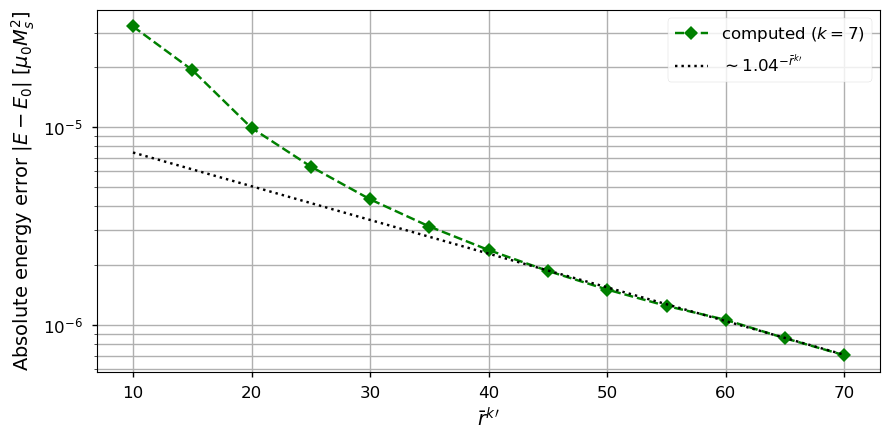

In [17]:
hosf_result = pd.read_csv("results/energy_uniform.csv")
k = 7
res = hosf_result[hosf_result.k == k]
with style.context("seaborn-v0_8-notebook"):
    plt.figure(figsize=(9, 4.5))
    plt.plot(res.r, abs(res.energy - 1 / 6), "--D", color="green", label=f"computed ($k={k}$)")
    plt.plot(res.r, [1.1e-5 * 1.04 ** (-_r) for _r in res.r], ":", color="k", label=r"$\sim 1.04^{-\bar r^k{'}}$")
    plt.legend()
    plt.xlabel(r"$\bar r^k{'}$", fontsize=14)
    plt.ylabel(r"Absolute energy error $|E - E_0|$ $[\mu_0 M_s^2]$", fontsize=14)
    plt.gca().tick_params(axis='both', which='major', labelsize=12)
    plt.legend(fontsize=12)
    plt.grid(which="both")
    plt.yscale("log")
    plt.tight_layout()
        
    plt.savefig("results/uniform_mag_rate_k7.pdf")
plt.show()

Next, we measure the time complexity for $k=7$ and varying multilinear rank $r$ and compare to TG and mumax$^3$.

In [ ]:

e_true = 1 / 6
k = 7
rs = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]

for r in rs:
    model, mag_model = make_cube_model(k, r), make_cube_model(k, r_mag)
    solver = setup(model, target_tg, mag_model=mag_model, s=100)
    mag = fit_mag(solver, m_uniform)  # prefit magnetization to functional Tucker format
    e = solve(solver, mag).block_until_ready()
    err = jnp.abs(e - e_true)
    t = %timeit -q -o -n 5 -r 1 solve(solver, mag).block_until_ready()
    print(f"k={k}, r={r}, energy={e:.6e}, error={err:.4e}, fitting_time={t.average * 1000:.3f} ms")
    data = {
        "k": k,
        "r": r,
        "s": 100,
        "energy": e,
        "error": jnp.abs(e - 1 / 6),
        "run_time": t.average
    }
    write_csv_row("results/energy_uniform_t.csv", data)

k=7, n=5, energy=1.670163e-01, error=3.4966e-04, fitting_time=4.300 ms
k=7, n=10, energy=1.666989e-01, error=3.2194e-05, fitting_time=4.611 ms
k=7, n=20, energy=1.666766e-01, error=9.8896e-06, fitting_time=6.941 ms
k=7, n=30, energy=1.666710e-01, error=4.3104e-06, fitting_time=10.167 ms
k=7, n=40, energy=1.666691e-01, error=2.3891e-06, fitting_time=14.553 ms
k=7, n=50, energy=1.666682e-01, error=1.5085e-06, fitting_time=20.830 ms
k=7, n=60, energy=1.666677e-01, error=1.0607e-06, fitting_time=29.458 ms
k=7, n=70, energy=1.666674e-01, error=7.0331e-07, fitting_time=36.583 ms
k=7, n=80, energy=1.666672e-01, error=5.1923e-07, fitting_time=45.399 ms
k=7, n=90, energy=1.666672e-01, error=4.8494e-07, fitting_time=56.508 ms
k=7, n=100, energy=1.666670e-01, error=3.5314e-07, fitting_time=69.856 ms
k=7, n=110, energy=1.666670e-01, error=3.1863e-07, fitting_time=83.334 ms
k=7, n=120, energy=1.666667e-01, error=8.0953e-09, fitting_time=98.951 ms


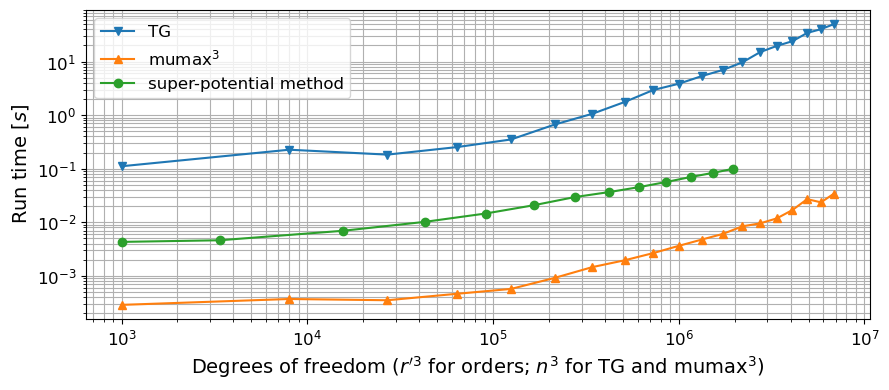

In [5]:

fig = plt.figure(figsize=(9, 4))
hosf_result = pd.read_csv("results/energy_uniform_t.csv")

plt.plot(tg_result.DoF[:-1], tg_result["cpu-times(s)"][:-1], "-v", label="TG")
plt.plot(mumag3_result.DoF[:-1], mumag3_result.eval_time[:-1], "-^", label=r"mumax$^3$")

res = hosf_result
k = hosf_result.k[0]
plt.plot((res.r + k - 2)**3, res.run_time, "-o", label = f"super-potential method")
    
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"Degrees of freedom ($r'^3$ for orders; $n^3$ for TG and mumax$^3$)", fontsize=14)
plt.ylabel(r"Run time $[s]$", fontsize=14)
plt.grid(which="both")
plt.legend(fontsize=12)
plt.gca().tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()
fig.savefig("results/run_time.pdf")

We can compare convergence of the super-potential method with the Newton-potential method in terms of the number of terms $S$ in the exponential sum to see that the super-potential method indeed converges faster due to a lower cut-off error.

In [ ]:
k = 9
r = 70
ss = [40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

for s in ss:
    model, mag_model = make_cube_model(k, r), make_cube_model(k, r_mag)
    solver = setup(model, target_tg, s=s, mag_model=mag_model, potential="superpotential")
    mag = fit_mag(solver, m_uniform)  # prefit magnetization to functional Tucker format
    e = solve(solver, mag)
    t = %timeit -q -o -n 5 -r 1 solve(solver, mag).block_until_ready()
    data = {
        "k": k,
        "r": r,
        "s": s,
        "energy": e,
        "error": jnp.abs(e - 1 / 6),
        "run_time": t.average
    }
    write_csv_row("results/energy_uniform_s_sp.csv", data)

In [ ]:
k = 9
r = 70
ss = [40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

for s in ss:
    model, mag_model = make_cube_model(k, r), make_cube_model(k, r_mag)
    solver = setup(model, target_tg, s=s, mag_model=mag_model, potential="newtonpotential")
    mag = fit_mag(solver, m_uniform)  # prefit magnetization to functional Tucker format
    e = solve(solver, mag)
    t = %timeit -q -o -n 5 -r 1 solve(solver, mag).block_until_ready()
    data = {
        "k": k,
        "r": r,
        "s": s,
        "energy": e,
        "error": jnp.abs(e - 1 / 6),
        "run_time": t.average
    }
    write_csv_row("results/energy_uniform_s_np.csv", data)

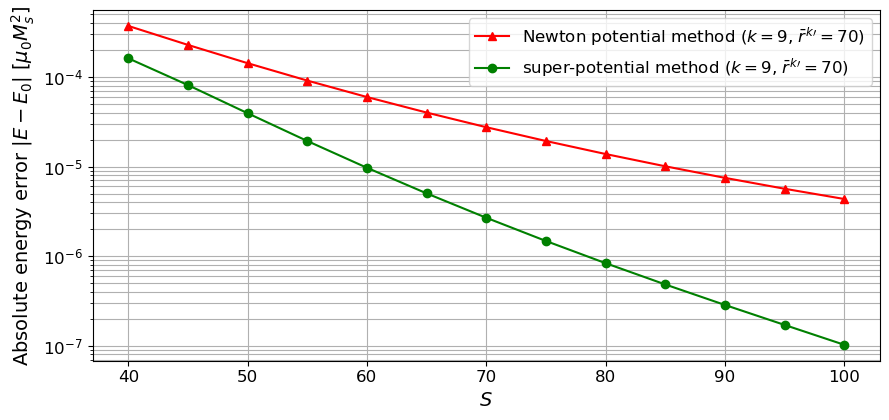

In [19]:
fig = plt.figure(figsize=(9, 4.3))
hosf_result = pd.read_csv("results/energy_uniform_s_np.csv")
ss = hosf_result.s.unique()
k = hosf_result.loc[0].k
r = hosf_result.loc[0].r

plt.plot(ss, abs(hosf_result.energy - 1 / 6), "-^", color="red", label=f"Newton potential method ($k={k:.0f}$, $\\bar r^k{{'}}={r:.0f}$)")

hosf_result = pd.read_csv("results/energy_uniform_s_sp.csv")
ss = hosf_result.s.unique()
k = hosf_result.loc[0].k
r = hosf_result.loc[0].r

plt.plot(ss, abs(hosf_result.energy - 1 / 6), "-o", color="green", label=f"super-potential method ($k={k:.0f}$, $\\bar r^k{{'}}={r:.0f}$)")

plt.xlabel("$S$", fontsize=14)
plt.ylabel(r"Absolute energy error $|E - E_0|$ $[\mu_0 M_s^2]$", fontsize=14)
plt.legend(fontsize=12)
plt.gca().tick_params(axis='both', which='major', labelsize=12)
plt.yscale("log")
plt.grid(which="both")
plt.tight_layout()

plt.savefig("results/uniform_np_sp_comparison.pdf")

## Energy for flower and vortex state

We also compute the energy for a flower and vortex state. To fit the magnetization, we use a rank $\bar r^k=40$ for the flower state and $\bar r^k=80$ for the vortex state with the same order $k$ as for the field computation. For a more accurate result we use $n_p=300$ quadrature nodes for $p=1,2,3$.

### Flower state:

In [ ]:
jax.clear_caches()
target_tg = TensorGrid(*[jnp.linspace(-0.5, 0.5, 2)] * 3).to_gauss(300)
r_mag = 40

# flower state
for k in [4, 5, 6, 7, 8]:
    for r in [10, 20, 40, 80]:
        model, mag_model = make_cube_model(k, r), make_cube_model(k, r_mag)
        solver = setup(model, target_tg, mag_model=mag_model)
        mag = fit_mag(solver, flower_state)  # prefit magnetization to functional Tucker format
        e = solve(solver, mag).block_until_ready()
        t = %timeit -q -o -n 10 -r 1 solve(solver, mag).block_until_ready()
        print(f"k={k}, r={r}, energy={e:.6e}, fitting_time={t.average * 1000:.3f} ms")
        data = {
            "k": k,
            "r": r,
            "s": 100,
            "energy": e,
            "run_time": t.average
        }
        write_csv_row("results/energy_flower.csv", data)

k=4, r=10, energy=1.481198e-01, fitting_time=5.405 ms
k=4, r=20, energy=1.515203e-01, fitting_time=8.287 ms
k=4, r=40, energy=1.525045e-01, fitting_time=16.393 ms
k=4, r=80, energy=1.527533e-01, fitting_time=51.354 ms
k=5, r=10, energy=1.530675e-01, fitting_time=6.365 ms
k=5, r=20, energy=1.530602e-01, fitting_time=9.131 ms
k=5, r=40, energy=1.529058e-01, fitting_time=18.112 ms
k=5, r=80, energy=1.528369e-01, fitting_time=57.072 ms
k=6, r=10, energy=1.530650e-01, fitting_time=6.136 ms
k=6, r=20, energy=1.528631e-01, fitting_time=9.930 ms
k=6, r=40, energy=1.528162e-01, fitting_time=18.682 ms
k=6, r=80, energy=1.528046e-01, fitting_time=57.443 ms
k=7, r=10, energy=1.528492e-01, fitting_time=7.048 ms
k=7, r=20, energy=1.528131e-01, fitting_time=10.887 ms
k=7, r=40, energy=1.528037e-01, fitting_time=20.061 ms
k=7, r=80, energy=1.528014e-01, fitting_time=59.310 ms
k=8, r=10, energy=1.528186e-01, fitting_time=7.524 ms
k=8, r=20, energy=1.528040e-01, fitting_time=11.240 ms
k=8, r=40, energy=

### Vortex state:

In [ ]:
energies_vortex = defaultdict(dict)
r_mag = 80
# vortex state
for k in [4, 5, 6, 7, 8]:
    for r in [10, 20, 40, 80]:
        model, mag_model = make_cube_model(k, r), make_cube_model(k, r_mag)
        solver = setup(model, target_tg, mag_model=mag_model)
        mag = fit_mag(solver, vortex_state)  # prefit magnetization to functional Tucker format
        e = solve(solver, mag).block_until_ready()
        energies_vortex[k][r] = e
        t = %timeit -q -o -n 10 -r 1 solve(solver, mag).block_until_ready()
        print(f"k={k}, r={r}, energy={e:.6e}, fitting_time={t.average * 1000:.3f} ms")
        data = {
            "k": k,
            "r": r,
            "s": 100,
            "energy": e,
            "run_time": t.average
        }
        write_csv_row("results/energy_vortex.csv", data)

k=4, r=10, energy=1.828363e-02, fitting_time=13.693 ms
k=4, r=20, energy=2.083906e-02, fitting_time=22.488 ms
k=4, r=40, energy=2.153607e-02, fitting_time=40.220 ms
k=4, r=80, energy=2.173305e-02, fitting_time=113.084 ms
k=5, r=10, energy=2.119882e-02, fitting_time=14.717 ms
k=5, r=20, energy=2.189389e-02, fitting_time=22.007 ms
k=5, r=40, energy=2.185375e-02, fitting_time=39.382 ms
k=5, r=80, energy=2.181843e-02, fitting_time=123.330 ms
k=6, r=10, energy=2.386479e-02, fitting_time=14.685 ms
k=6, r=20, energy=2.184147e-02, fitting_time=23.279 ms
k=6, r=40, energy=2.180779e-02, fitting_time=38.853 ms
k=6, r=80, energy=2.179918e-02, fitting_time=113.476 ms
k=7, r=10, energy=2.238066e-02, fitting_time=15.301 ms
k=7, r=20, energy=2.180317e-02, fitting_time=25.743 ms
k=7, r=40, energy=2.179798e-02, fitting_time=46.504 ms
k=7, r=80, energy=2.179680e-02, fitting_time=119.237 ms
k=8, r=10, energy=1.692305e-02, fitting_time=15.944 ms
k=8, r=20, energy=2.179745e-02, fitting_time=23.540 ms
k=8, r

## Vortex state in a thin film

For other domains, such as a thin film $[-0.5, 0.5]\times [-0.5, 0.5] \times [-0.05, 0.05]$ we need to adjust the spline model and the quadrature tensor grid. As a reference we have $e_d=0.001562$ computed by *mumax3*. We use $300\times300\times75$ quadrature points. We use a multilinear rank $(\bar r_1^k,\bar r_2^k, \bar r_3^k)=(40, 40, 10)$ to fit the magnetization.

In [14]:
# thin film
jax.clear_caches()
target_tg = TensorGrid(
    jnp.array([-0.5, 0.5]),
    jnp.array([-0.5, 0.5]),
    jnp.array([-0.05, 0.05]),
).to_gauss((300, 300, 75))


for k in [5, 6, 7, 8]:
    for r in [20, 40, 60]:
        grid = TensorGrid(
            jnp.linspace(-0.5, 0.5, r),
            jnp.linspace(-0.5, 0.5, r),
            jnp.linspace(-0.05, 0.05, r // 4)
        )
        mag_grid = TensorGrid(
            jnp.linspace(-0.5, 0.5, 40),
            jnp.linspace(-0.5, 0.5, 40),
            jnp.linspace(-0.05, 0.05, 10)
        )
        mag_model = BSpline(mag_grid, degree=k - 1)
        model = BSpline(grid, degree=k - 1)
        solver = setup(model, target_tg, mag_model=mag_model)
        mag = fit_mag(solver, vortex_state)  # prefit magnetization to functional Tucker format
        e = solve(solver, mag).block_until_ready()
        t = %timeit -q -o -n 10 -r 1 solve(solver, mag).block_until_ready()
        print(f"k={k}, r={r}, energy={e:.6e}, fitting_time={t.average * 1000:.3f} ms")
        data = {
            "k": k,
            "r": r,
            "s": 100,
            "energy": e,
            "run_time": t.average
        }
        write_csv_row("results/energy_votex_thin_film.csv", data)

k=5, r=20, energy=1.531735e-03, fitting_time=4.365 ms
k=5, r=40, energy=1.567055e-03, fitting_time=7.684 ms
k=5, r=60, energy=1.569947e-03, fitting_time=12.171 ms
k=6, r=20, energy=1.564455e-03, fitting_time=4.843 ms
k=6, r=40, energy=1.569470e-03, fitting_time=6.973 ms
k=6, r=60, energy=1.568540e-03, fitting_time=10.869 ms
k=7, r=20, energy=1.569056e-03, fitting_time=6.456 ms
k=7, r=40, energy=1.567672e-03, fitting_time=9.642 ms
k=7, r=60, energy=1.567491e-03, fitting_time=17.103 ms
k=8, r=20, energy=1.567789e-03, fitting_time=6.920 ms
k=8, r=40, energy=1.567110e-03, fitting_time=10.038 ms
k=8, r=60, energy=1.567297e-03, fitting_time=16.452 ms


## Thin film with two layers

In this example we demonstrate the higher order stray field method for a thin film with two layers. The top layer $\Omega_1=[-0.4, 0.5]\times[-0.5, 0.5]\times[0, 0.05]$ has a uniform magnetization in the $[0.4, 1, 0.6]^T$ direction and the bottom layer $\Omega_2=[-0.5, 0.4]\times[-0.5, 0.5]\times[-0.05, 0]$ has a uniform magnetization in the $[-1, -0.3, 0.0]^T$ direction. Additionally, we use $M_{s,\Omega_1} = 1$ in $\Omega_1$ and $M_{s, \Omega_2}=2$ in $\Omega_2$. For each domain we use a B-Spline TPELM with $k=9$ with grid ranks $(n_k^{1}{'},n_k^2{'},n_k^3{'})=(40,40,5)$ to fit the superpotential. Further, we use $(200\times200\times25)$ quadrature nodes.

In [20]:
jax.clear_caches()
r = 40
k = 8

unit_vec = lambda x: x / jnp.linalg.norm(x, keepdims=True)
m1 = lambda x: unit_vec(jnp.array([0.4, 1, 0.6]))
m2 = lambda x: unit_vec(jnp.array([-1, -0.3, 0.0])) * 2  # Ms = 2

magnetization = {
    0: m1,
    1: m2,
}


grid1 = TensorGrid(
    jnp.linspace(-0.4, 0.5, r),
    jnp.linspace(-0.5, 0.5, r),
    jnp.linspace(0.0, 0.05, r // 8),
)
grid2 = TensorGrid(
    jnp.linspace(-0.5, 0.4, r),
    jnp.linspace(-0.5, 0.5, r),
    jnp.linspace(-0.05, 0.0, r // 8),
)

mag_grid1 = TensorGrid(
    jnp.linspace(-0.4, 0.5, 30),
    jnp.linspace(-0.5, 0.5, 30),
    jnp.linspace(0.0, 0.05, 4),
)
mag_grid2 = TensorGrid(
    jnp.linspace(-0.5, 0.4, 30),
    jnp.linspace(-0.5, 0.5, 30),
    jnp.linspace(-0.05, 0.0, 4),
)

targets = {
    0: TensorGrid(
        jnp.linspace(-0.4, 0.5, 2),
        jnp.linspace(-0.5, 0.5, 2),
        jnp.linspace(0.0, 0.05, 2),
    ).to_gauss((200, 200, 25)),
    1: TensorGrid(
        jnp.linspace(-0.5, 0.4, 2),
        jnp.linspace(-0.5, 0.5, 2),
        jnp.linspace(-0.05, 0.0, 2),
    ).to_gauss((200, 200, 25))
}

models = {
    0: BSpline(grid1, degree=k - 1),
    1: BSpline(grid2, degree=k - 1),
}

mag_models = {
    0: BSpline(mag_grid1, degree=k - 1),
    1: BSpline(mag_grid2, degree=k - 1),
}

solver = setup(models, targets, mag_model=mag_models, s=100)
mag = fit_mag(solver, magnetization)  # prefit magnetization to functional Tucker format
e = solve(solver, mag).block_until_ready()
e

Array(0.01086307, dtype=float64)